In [466]:
import numpy as np
import matplotlib.pyplot as plt

In [467]:
import numpy as np
from scipy.signal import cont2discrete
import matplotlib.pyplot as plt
import import_ipynb
import control

In [468]:
# MPC gain
t0 = 0
T = 20
N_sim = 900
dt = (T-t0)/N_sim
print(dt)

Np = 20  # predictive states
Nc = 4   # future output

0.022222222222222223


In [469]:
reference= []

for i in range(1, N_sim+Np):
    reference.append([(30-i*dt*1.5)*np.cos(i*dt*2), (30-i*dt*1.5)*np.sin(i*dt*2), i*dt*2])

In [470]:
import plotly.graph_objs as go
import numpy as np


trace = go.Scatter3d(
   x = np.array(reference)[:, 0], 
   y = np.array(reference)[:, 1], 
   z = np.array(reference)[:, 2],
   mode = 'markers', 
   marker = dict(
      size = 1, 
      colorscale = 'Bluered_r'
      )
   )

layout = go.Layout(title = '3차원 산점도 (3D Scatter plot)', width=700, height=1000)

fig = go.Figure(data = [trace], layout = layout)
#fig.add_trace(trace_ref)


fig.show()

In [471]:
A = np.zeros(6*6).reshape(6, 6)
A[:3, 3:6] = np.eye(3)

B = np.zeros(6*3).reshape(6, 3)
B[3:, :] = np.eye(3)

C = np.zeros(3*6).reshape(3, 6)
C[:, :3] = np.eye(3)

D = 0

In [472]:
Ad, Bd, Cd, Dd, _ = cont2discrete((A, B, C, D), dt)

In [473]:
Phi, F, Ae, Be, Ce = control.mpcgain(Ad, Bd, Cd, Nc, Np)

In [474]:
print(reference[0])

[29.937074830413025, 1.3314134254100034, 0.044444444444444446]


In [598]:
u_ = np.array([0, 0, 0]).reshape(-1, 1)
y_ = np.array([0, 0, 0]).reshape(-1, 1)

y_[0] = 40

R_bar = np.eye(12) * 50
Q = np.eye(Phi.shape[0]) * 360

N_outputs, N_states = Bd.shape
# 그냥 초기값을 0으로 하는 듯
xf = np.zeros((Bd.shape[0] + Cd.shape[0], 1))
xm = np.zeros(6).reshape(6, 1)

xm[0] = 40

l = [xf]
ll = [xm]
ul = [u_]
tl = [0]
dt = 0.01

for k in range(N_sim):
    
    ref = np.array(reference[k]).reshape(-1, 1)
    for i in range(k, k+Np-1):
        ref = np.concatenate([ref, np.array(reference[i]).reshape(-1, 1)], axis=0)
    #print(ref)
    DeltaU = np.linalg.inv((Phi.T@Q@Phi) + R_bar).dot(Phi.T@Q@(ref - F @ xf))
    deltau = DeltaU[:u_.shape[0], :]
    
    xm_old = xm.copy()

    xm = Ad@xm + Bd@u_
    ll.append(xm)
    y_ = Cd@xm
    
    xf = np.concatenate((xm - xm_old, y_), axis=0)
    
    u_ = u_ + deltau
    ul.append(u_)
    
    tl.append(dt*k)
    

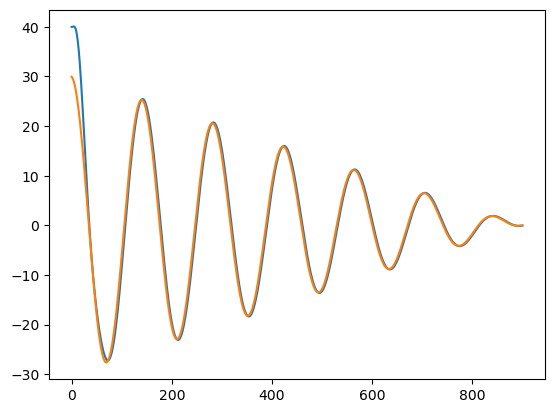

In [599]:
idx = 0

plt.plot(np.array(ll)[:, idx, :])
plt.plot(np.array(reference)[:, idx][:-Np+1])

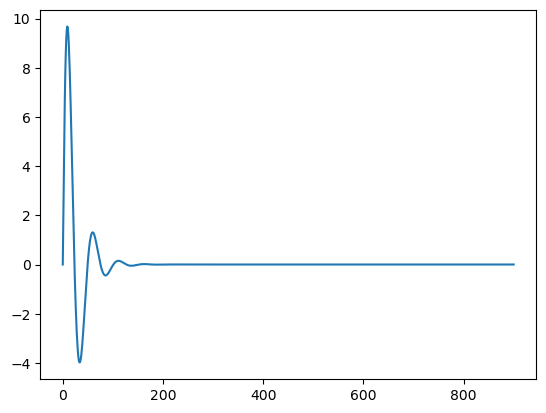

In [600]:
plt.plot(np.array(ul)[:, 2])

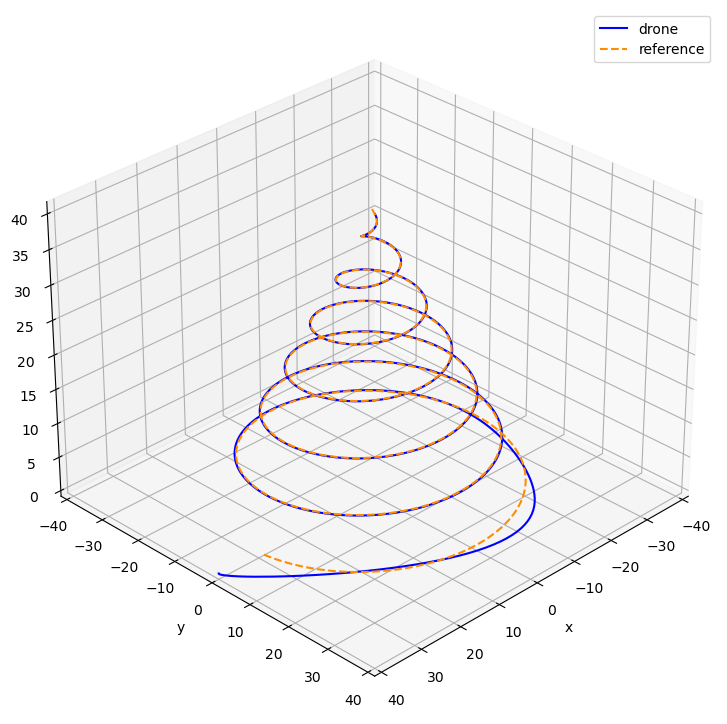

In [601]:
#x = np.linspace(0, 20, 1000)
#y, z = 10.*np.cos(x), 10.*np.sin(x) # something simple
x = np.array(ll)[:, 0]
y = np.array(ll)[:, 1]
z = np.array(ll)[:, 2]

reference_x = np.array(reference)[:, 0]
reference_y = np.array(reference)[:, 1]
reference_z = np.array(reference)[:, 2]

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1,2,1,projection='3d')
ax.plot(x, y, z, label="drone", color="blue")
ax.plot(reference_x, reference_y, reference_z, "--", label="reference", color="darkorange")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.xlim(-40, 40)
plt.ylim(-40, 40)
ax.legend()

ax.view_init(30, 45)

plt.savefig("R50, Q360")